#### Imports:

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import os
import tqdm
import re
import random
import statistics as stats
from skimage import io, measure, color
import cv2
from scipy import ndimage as ndi
from skimage.segmentation import flood, flood_fill
from boundary_approximation import *
from collections import Counter
%matplotlib inline

#### Functions:

In [69]:
def mode_colour(img,region_cols,fill_colour,boundary=10):
    # Get average background colour:
    b = [np.average(img[np.shape(img)[0]-boundary:,0:boundary,0]),
         np.average(img[np.shape(img)[0]-boundary:,0:boundary,1]),np.average(img[np.shape(img)[0]-boundary:,0:boundary,2])]
    # Find colour of pixels in region, and round them to the nearest multiple of 5:
    avg_bg = pixel_col_round(b)
    tst_2 = [str(pixel_col_round(p)) for p in region_cols if pixel_col_round(p)!=avg_bg]
    # Find mode colour:
    a = stats.mode(tst_2)
    mode = np.int_(re.findall('\d+',a))
    # Find mode backround colour:
    pix = img[np.shape(img)[0]-boundary:,0:boundary]
    new_arr = pix.reshape(-1, pix.shape[-1])
    pix_round = [str(pixel_col_round(v)) for v in new_arr]
    try:
        mode_bg = np.int_(re.findall("\d+",stats.mode(pix_round)))
    except:
        mode_bg = avg_bg
    # Check whether mode colour is contrasting with mode background colour:
    if sum(abs(mode-mode_bg)) <= 20:
        total_counts = Counter(tst_2)
        total_counts_ = list(total_counts.values())
        vals = np.array(list(total_counts.keys()))[np.where(total_counts_>=np.percentile(total_counts_,99.9))[0]]
        k = np.argmax([sum(abs(np.int_(re.findall('\d+',v))-mode_bg)) for v in vals])
        mode = np.int_(re.findall("\d+",vals[k]))
    return mode

In [52]:
def pin_line_new(img, filtered_pin_contours,pin_k_inds,fill_colour=[255,0,0],nseg=30,boundary=10):
  
    filled_img = deepcopy(img)
    for pin_k in pin_k_inds:
        x = filtered_pin_contours[pin_k][0]
        y = filtered_pin_contours[pin_k][1]
        a3 = np.array([np.array([x,y]).T], dtype=np.int32 )
        cv2.fillPoly( filled_img, a3, fill_colour )
    
    inds_ = np.where(filled_img==fill_colour)[0:2]
    
    ##########################################################
    
    segments = np.int_(np.linspace(0,np.shape(img)[1],nseg+1))
    
    count_seg = [len(np.where(filled_img[:,segments[i-1]:segments[i]]==fill_colour)[0]) for i in range(1,len(segments))]

    a,b = [segments[np.argmax(count_seg)]-10,segments[np.argmax(count_seg)+1]+10]
    
    lines = []
    
    
    ###########################################################
    
    img2 = deepcopy(img)
    img2[inds_[0][np.where((inds_[1]<=b)&(inds_[1]>=a))[0]],inds_[1][np.where((inds_[1]<=b)&(inds_[1]>=a))[0]]] = fill_colour

    totals = [len(np.where(img2[:,v]==fill_colour)[0]) for v in range(a,b)]
    
    p = a+np.argmax(totals)
    
    #print([a,b,p])

        
    lines.append([p,np.shape(img)[0]-1])  

    ###########################################################
        
    region_cols = img[inds_[0][np.where((inds_[1]<=b)&(inds_[1]>=a))[0]],inds_[1][np.where((inds_[1]<=b)&(inds_[1]>=a))[0]]]

    ############################################################
    
    
    mode = mode_colour(img,region_cols,fill_colour,boundary=boundary)
    bla_img = convert_img(img,mode,new_col=fill_colour)

    count = [len(np.where(bla_img[:,i]==fill_colour)[0]) for i in range(0,np.shape(bla_img)[1])]

    p = np.argmax(count)

    lines.append([p,np.shape(img)[0]-1])      
    
    return lines, filled_img, img2, mode

In [67]:
def find_pin_location(filepath,edit_image=True,boundary=5):
    
    if edit_image == True:
    
        img_orig = io.imread(filepath)

        b = [np.average(img_orig[np.shape(img_orig)[0]-boundary:,0:boundary,0]),
             np.average(img_orig[np.shape(img_orig)[0]-boundary:,0:boundary,1]),
             np.average(img_orig[np.shape(img_orig)[0]-boundary:,0:boundary,2])]

        lb = int(np.floor(min(b)))-5
        ub = int(np.ceil(max(b)))+5

        img = deepcopy(img_orig)

        img[:boundary,:] = np.random.randint(lb,ub,size=np.shape(img_orig[:boundary,:]))
        img[-boundary:,:] = np.random.randint(lb,ub,size=np.shape(img_orig[:boundary,:]))
        img[:,:boundary] = np.random.randint(lb,ub,size=np.shape(img_orig[:,:boundary]))
        img[:,-boundary:] = np.random.randint(lb,ub,size=np.shape(img_orig[:,:boundary]))

        cv2.imwrite("test_img.JPG", img)

        img = io.imread("test_img.JPG")

        img_bw = io.imread("test_img.JPG",as_gray=True)
        
        top_contours = find_top_contours(img_bw,k=20,modification=boundary)
        
    else:
        img = io.imread(filepath)
        img_bw = io.imread(filepath,as_gray=True)
        
        top_contours = find_top_contours(img_bw,k=20)


    # Find (assumed) pin-related contours:
    
    pin_contours, base_point =  find_pin_contours(top_contours)

    # Create approximate boundary ellipse:
    xe, ye, ellipse_info = init_region_ellipse(pin_contours, base_point)

    # Filter for contours that pass through boundary:
    filtered_pin_contours, pin_k = filter_pin_contours(pin_contours,ellipse_info)
    bla = [
                (max(xy[1]) - min(xy[1]))
                for xy in filtered_pin_contours
            ]

    pin_k_inds = np.where(np.array(bla)>np.percentile(bla,50))[0]

    lines, f_image, img_edited, mode_col = pin_line_new(img, filtered_pin_contours,pin_k_inds,boundary=boundary)
    
    return lines,img,f_image,img_edited, mode_col

### Single Image Test

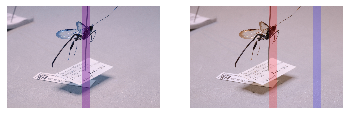

In [44]:
pth = 'Data\\Sample\\013612434_additional_1.JPG'
lines1,img1,f_image1,img_edited1 = find_pin_location(pth,edit_image=True)
lines2,img2,f_image2,img_edited2 = find_pin_location(pth,edit_image=False)

# Plot:
fig,ax = plt.subplots(1,2)

line1,line2 = lines1
ax[0].imshow(img1)
ax[0].plot([line1[0],line1[0]],[0,line1[1]],'-r',linewidth=8,alpha=0.2)
ax[0].plot([line2[0],line2[0]],[0,line2[1]],'-b',linewidth=8,alpha=0.2)

line1,line2 = lines2
ax[1].imshow(img2)
ax[1].plot([line1[0],line1[0]],[0,line1[1]],'-r',linewidth=8,alpha=0.2)
ax[1].plot([line2[0],line2[0]],[0,line2[1]],'-b',linewidth=8,alpha=0.2)

for i in range(0,2):
    ax[i].axis('off')

### Automated Tests

#### Data:

In [39]:
filenames = []

for file in os.listdir("Data//Sample"):
    filenames.append("Data//Sample//"+file)
    
sample_filenames = random.sample(filenames,5)

#### Small-Scale Tests:

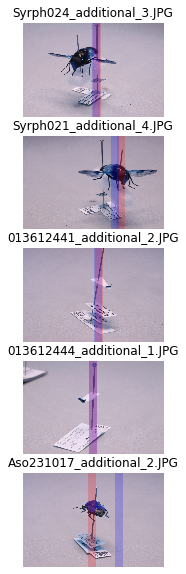

In [41]:
fig,ax = plt.subplots(5,1,figsize=(15,10))

j = 0

for u,filepath in enumerate(sample_filenames):
    i = u%5
    
    lines,img,f_image,img_edited = find_pin_location(filepath)

    line1,line2 = lines
    
    # Plot:
    ax[i].imshow(img)
    ax[i].plot([line1[0],line1[0]],[0,line1[1]],'-r',linewidth=8,alpha=0.2)
    ax[i].plot([line2[0],line2[0]],[0,line2[1]],'-b',linewidth=8,alpha=0.2)
    ax[i].axis('off')
    ax[i].set_title(filepath[14:])

    ########################################################
    
    if i == 4:
        j = j+1

#### Large-Scale Tests:

In [ ]:
sample_pth = "Data\\Sample"
new_pth = "Data\\Tests\\"

all_colours = []
all_lines = []
all_filenames = []

errors = []

for file in tqdm.tqdm(os.listdir(sample_pth)):
    try:
        
        plt.close()
    
        all_filenames.append(file)

        lines,img,f_image,img_edited, mode_col = find_pin_location(sample_pth+"\\"+file)

        all_lines.append(lines)
        all_colours.append(mode_col)

        # Plot:
        fig,ax = plt.subplots()

        line1,line2 = lines
        ax.imshow(img)
        ax.plot([line1[0],line1[0]],[0,line1[1]],'-r',linewidth=8,alpha=0.2)
        ax.plot([line2[0],line2[0]],[0,line2[1]],'-b',linewidth=8,alpha=0.2)

        ax.axis('off')

        plt.savefig(new_pth+file,dpi=600,bbox_inches='tight',pad_inches=0.0)

        plt.close()
        
    except:
        errors.append(file)


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [51:55<00:00,  2.46s/it]